In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

W0826 10:28:09.611510 4450395584 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



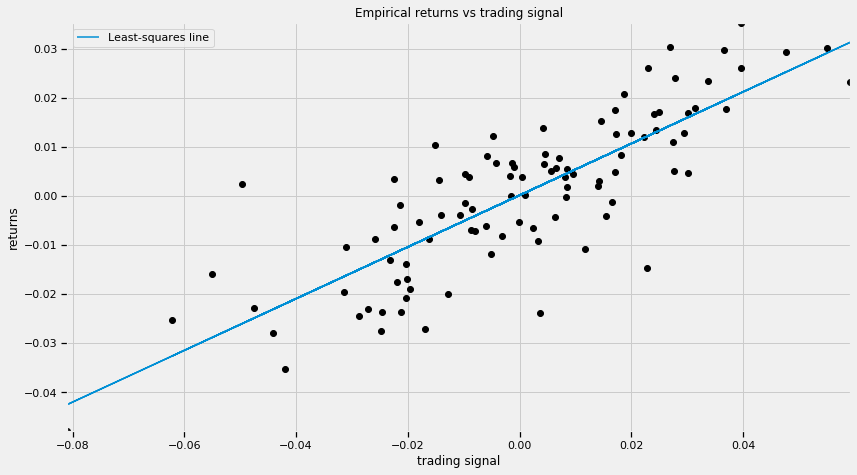

In [106]:
# Code for creating artificial "dummy" data
# This is a common strategy for testing our models
# before applying it to real-world data

reset_sess()  # Resets the default tensorflow graph we're using

num_data = 100
X_data = tf.to_float(
    0.025 
    * tfd.Normal(loc=0., 
                 scale=1.).sample(
        sample_shape=num_data))
Y_data = tf.to_float(
    0.5 * X_data + 0.01 
    * tfd.Normal(loc=0., 
                 scale=1.).sample(
        sample_shape=num_data))

def tf_cov(x):
    mean_x = tf.reduce_mean(x, axis=0, keepdims=True)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    return cov_xx

tf_cov_data = tf_cov(tf.stack([X_data, Y_data], 1))
tf_var_data = tf.nn.moments(X_data, axes=0)[1]
  
ls_coef = tf_cov_data[0, 1] / tf_var_data

[
    X_data_, Y_data_, ls_coef_, tf_cov_data_, tf_var_data_
] = evaluate([
    X_data, Y_data, ls_coef, tf_cov_data, tf_var_data
])

ls_intercept = Y_data_.mean() - ls_coef_ * X_data_.mean()

plt.figure(figsize(12.5, 7))
plt.scatter(X_data_, Y_data_, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X_data_, ls_coef_ * X_data_ + ls_intercept, label="Least-squares line")
plt.xlim(X_data_.min(), X_data_.max())
plt.ylim(Y_data_.min(), Y_data_.max())
plt.legend(loc="upper left");

We perform a simple Bayesian linear regression on this dataset. We look for a model like:
$$
R = \alpha + \beta x + \epsilon
$$

where $\alpha$, $\beta$ are our unknown parameters and $\epsilon\sim\mathrm{Normal}(0, 1/\tau)$. The most common priors on $\beta$ and $\alpha$ are Normal priors. We will also assign a prior on $\tau$, so that $\sigma = 1/\sqrt{\tau}$ is uniform over 0 to 100 (equivalently then $\tau = 1/\mathrm{Uniform}(0, 100)^2)$.

In [107]:
obs_stdev = tf.sqrt(
        tf.reduce_mean(tf.squared_difference(Y_data_, tf.reduce_mean(Y_data_, axis=0)),
                      axis=0))

# Let's define the log probability of the bayesian regression function
def finance_posterior_log_prob(X_data_, Y_data_, alpha, beta, sigma):
    """
    Our posterior log probability, as a function of states
    
    Args:
      alpha_: scalar, taken from state of the HMC
      beta_: scalar, taken from state of the HMC
      sigma_: scalar, the standard deviation of , taken from state of the HMC
    Returns: 
      Scalar sum of log probabilities
    Closure over: Y_data, X_data
    """
    rv_std = tfd.Uniform(name="std", low=0., high=100.)
    rv_beta = tfd.Normal(name="beta", loc=0., scale=100.)
    rv_alpha = tfd.Normal(name="alpha", loc=0., scale=100.)
    
    mean = alpha + beta * X_data_
    rv_observed = tfd.Normal(name="obs", loc=mean, scale=sigma)
    
    return (
        rv_alpha.log_prob(alpha) 
        + rv_beta.log_prob(beta) 
        + rv_std.log_prob(sigma)
        + tf.reduce_sum(rv_observed.log_prob(Y_data_))
    )

In [99]:
reset_sess()

In [108]:
number_of_steps = 5000
burnin = 1000

# Set the chain's start state.
initial_chain_state = [
    tf.to_float(1.) * tf.ones([], name='init_alpha', dtype=tf.float32),
    tf.to_float(0.01) * tf.ones([], name='init_beta', dtype=tf.float32),
    tf.to_float(obs_stdev) * tf.ones([], name='init_sigma', dtype=tf.float32)
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity()
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: finance_posterior_log_prob(X_data_, Y_data_, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=3,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
            num_adaptation_steps=10),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sampling from the chain.
[
    alpha, 
    beta, 
    sigma
], kernel_results = tfp.mcmc.sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin,
    current_state=initial_chain_state,
    kernel=hmc,
    name='HMC_sampling'
) 
    
# Some of the steps of the MCMC will involve just getting close to where the right answers are
# so we get the samples random walk, and cut off the trial (or `burn_in`) steps    
burned_alpha_samples = alpha[burnin:]
burned_beta_samples = beta[burnin:]
burned_sigma_samples = sigma[burnin:]

# Initialize any created variables for preconditions
init_g = tf.global_variables_initializer()

In [109]:
# Running the Initializer on our model
evaluate(init_g)
  
# performing our computations
[
    burned_alpha_samples_,
    burned_beta_samples_,
    burned_sigma_samples_,
    kernel_results_
] = evaluate([
    burned_alpha_samples,
    burned_beta_samples,
    burned_sigma_samples,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))


acceptance rate: 0.0
final step size: 0.452643483877182


Text(0.5, 1.0, 'burned HMC alpha (α) convergence progression')

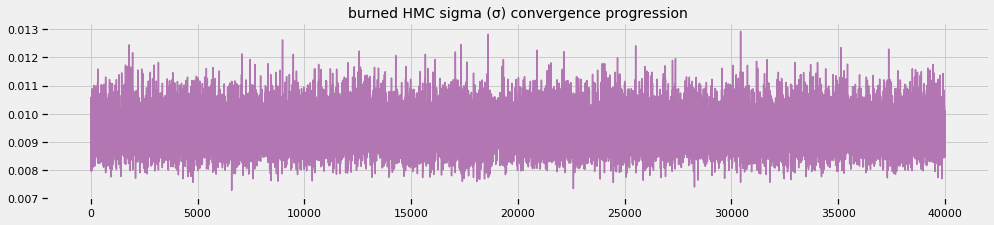

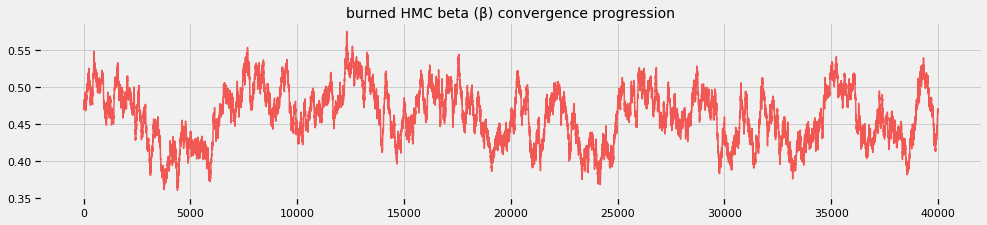

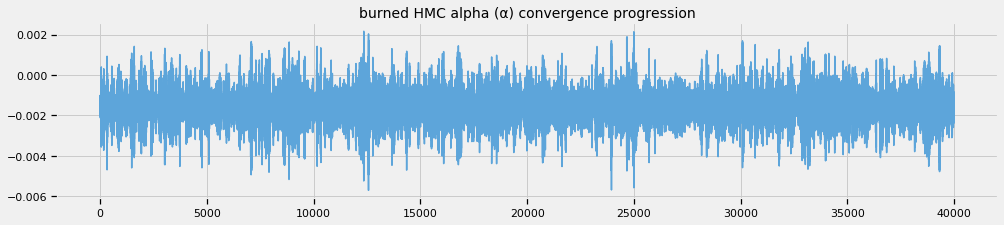

In [89]:
# plotting the Posterior Samples
plt.figure(figsize=(15,3))
plt.plot(np.arange(number_of_steps - burnin), burned_sigma_samples_, color=TFColor[6])
plt.title('burned HMC sigma (σ) convergence progression', fontsize=14)

plt.figure(figsize=(15,3))
plt.plot(np.arange(number_of_steps - burnin), burned_beta_samples_, color=TFColor[0])
plt.title('burned HMC beta (β) convergence progression', fontsize=14)

plt.figure(figsize=(15,3))
plt.plot(np.arange(number_of_steps - burnin), burned_alpha_samples_, color=TFColor[3])
plt.title('burned HMC alpha (α) convergence progression', fontsize=14)

In [94]:
number_of_steps=5000
# performing our computations for sampling the posterior

alpha_mean = tf.reduce_mean(burned_alpha_samples, axis=0)
alpha_stdev = tf.sqrt(
    tf.reduce_mean(tf.squared_difference(burned_alpha_samples, alpha_mean),
                  axis=0))
beta_mean = tf.reduce_mean(burned_beta_samples, axis=0)
beta_stdev = tf.sqrt(
    tf.reduce_mean(tf.squared_difference(burned_beta_samples, beta_mean),
                  axis=0))
sigma_mean = tf.reduce_mean(burned_sigma_samples, axis=0)
sigma_stdev = tf.sqrt(
    tf.reduce_mean(tf.squared_difference(burned_sigma_samples, sigma_mean),
                  axis=0))
    
# Getting 50,000 samples from the approximate posterior distribution
posterior_alpha_predictive_samples = tfd.Normal(loc=alpha_mean, 
                                                scale=alpha_stdev, 
                                                name='approx_alpha_posterior').sample(sample_shape=5000)
posterior_beta_predictive_samples = tfd.Normal(loc=beta_mean, 
                                               scale=beta_stdev, 
                                               name='approx_beta_posterior').sample(sample_shape=5000)
posterior_sigma_predictive_samples = tfd.Normal(loc=sigma_mean, 
                                                scale=sigma_stdev, 
                                                name='approx_prec_posterior').sample(sample_shape=5000)
[
    posterior_alpha_predictive_samples_,
    posterior_beta_predictive_samples_,
    posterior_sigma_predictive_samples_,
] = evaluate([
    posterior_alpha_predictive_samples,
    posterior_beta_predictive_samples,
    posterior_sigma_predictive_samples,
])

LinAlgError: singular matrix

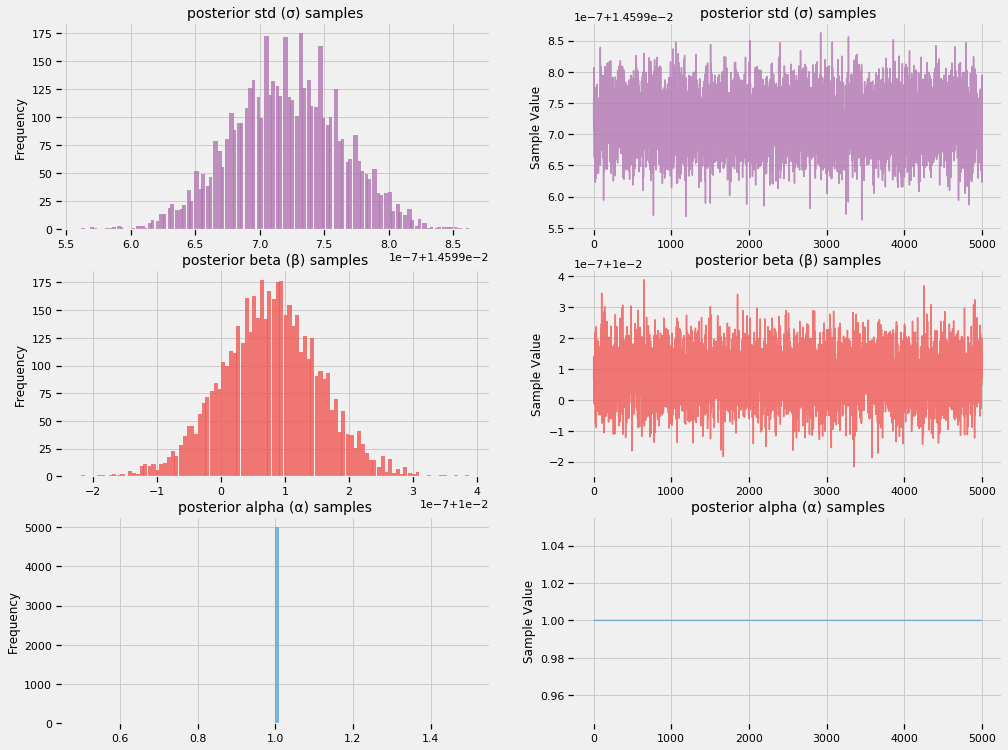

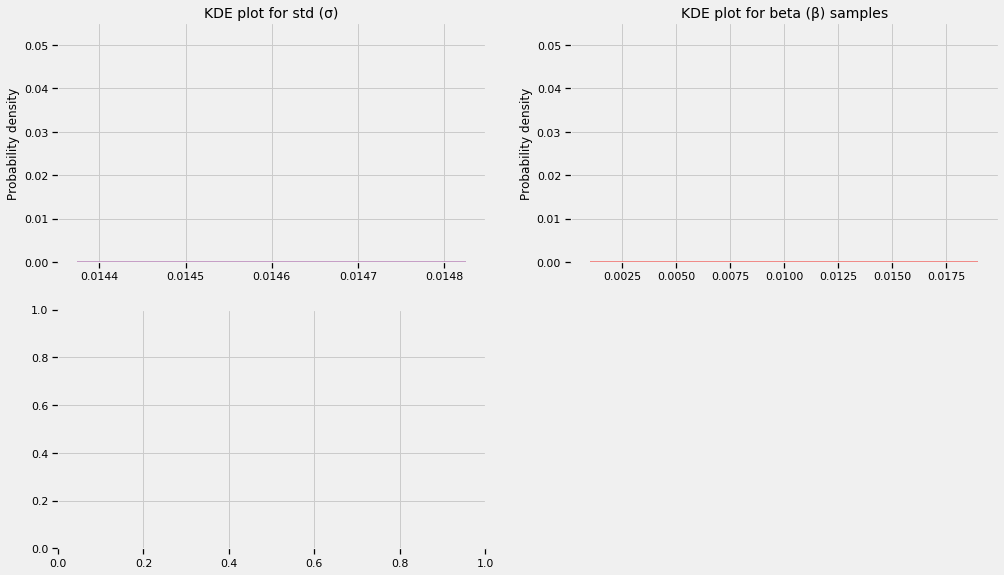

In [95]:
# plotting the Posterior Samples

plt.figure(figsize=(15,12))
plt.subplot(3, 2, 1)
plt.hist(posterior_sigma_predictive_samples_, 
         bins=100, color=TFColor[6], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior std (σ) samples', fontsize=14)
plt.subplot(3, 2, 2)
plt.plot(np.arange(number_of_steps), 
         posterior_sigma_predictive_samples_, color=TFColor[6], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior std (σ) samples', fontsize=14)

plt.subplot(3, 2, 3)
plt.hist(posterior_beta_predictive_samples_, 
         bins=100, color=TFColor[0], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior beta (β) samples', fontsize=14)
plt.subplot(3, 2, 4)
plt.plot(np.arange(number_of_steps), 
         posterior_beta_predictive_samples_, color=TFColor[0], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior beta (β) samples', fontsize=14)

plt.subplot(3, 2, 5)
plt.hist(posterior_alpha_predictive_samples_, bins=100, 
         color=TFColor[3], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior alpha (α) samples', fontsize=14)
plt.subplot(3, 2, 6)
plt.plot(np.arange(number_of_steps), posterior_alpha_predictive_samples_, 
         color=TFColor[3], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior alpha (α) samples', fontsize=14)

#KDE Plots
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.figure(figsize=(15,9))
plt.subplot(2, 2, 1)
ax1 = sns.kdeplot(posterior_sigma_predictive_samples_, 
                  shade=True, color=TFColor[6], bw=.000075)
plt.ylabel('Probability density')
plt.title('KDE plot for std (σ)', fontsize=14)
plt.subplot(2, 2, 2)
ax2 = sns.kdeplot(posterior_beta_predictive_samples_, 
                  shade=True, color=TFColor[0], bw=.0030)
plt.ylabel('Probability density')
plt.title('KDE plot for beta (β) samples', fontsize=14)
plt.subplot(2, 2, 3)
ax3 = sns.kdeplot(posterior_alpha_predictive_samples_, 
                  shade=True, color=TFColor[3], bw=.0001)
plt.ylabel('Probability density')
plt.title('KDE plot for alpha (α) samples', fontsize=14)

In [105]:
tfp.mcmc.make_simple_step_size_update_policy?